In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

In [2]:
def get_dataset(d, n_train, n_test):
  x_train = np.random.randn(n_train, d)
  x_test = np.random.randn(n_test, d)
  mean_train = np.empty(d)
  norm_tab = np.empty(n_train)

  norm_train = (np.sum(x_train * x_train, axis = 1) ** 0.5).reshape(n_train, 1)
  x_train = (x_train / norm_train) * (d ** 0.5)
      
  norm_test = (np.sum(x_test * x_test, axis = 1) **0.5).reshape(n_test, 1)
  x_test = (x_test / norm_test) * (d**0.5)

  #On vérifie que notre data set soit uniforme (sur chaque dimension, le dataset a à peu près une moyenne de 0)
  #On se rapproche de plus en plus de 0 lorsqu'on augmente n_train, les données étant mieux réparties
  mean_train = np.sum(x_train, axis = 0) / n_train
      
  #On vérifie que chaque élément de notre dataset ait une norme de sqrt(d)
  norm_tab = np.sum(x_train * x_train, axis = 1) ** 0.5
      
  tau = 0.
  noise_level = tau * tau
  #On veut E(noise) == 0 et E(noise^2) == tau^2
  noise_train = np.random.randn(n_train, 1) * noise_level
  noise_test = np.random.randn(n_test, 1) * noise_level

  F1 = 1

  sample_params = np.random.randn(d, 1)
      
  norm = np.sum(sample_params * sample_params) #should be equal to F1^2
  sample_params = sample_params * (F1 / (norm**0.5))

  y_train = np.dot(x_train, sample_params) + noise_train
  y_test = np.dot(x_test, sample_params) + noise_test

  return x_train, y_train, x_test, y_test

In [3]:
#Quelques fonctions d'activation :

class Sigmoid :
    @staticmethod
    def function(x):
        return 1/(1+np.exp(-x))
    
    @staticmethod
    def gradient(x):
        return Sigmoid.function(x) * Sigmoid.function(-x)
    
class Tanh :
    @staticmethod
    def function(x):
        return np.tanh(x)
        
    @staticmethod
    def gradient(x):
        t = Tanh.function(x)
        return 1-t**2
    
class Relu :
    @staticmethod
    def function(x):
        return np.maximum(x, 0)
    
    @staticmethod
    def gradient(x):
        return x >= 0

class Linear :
    @staticmethod
    def function(x):
        return x
    
    @staticmethod
    def gradient(x):
        return np.ones((x.shape[0], x.shape[1]))

In [4]:
#Quelques Loss Functions :
class MSE:
    @staticmethod
    def loss(y_real, y_hat):
        return np.mean(np.sum((y_hat.T - y_real.T)**2, axis = 0))    
    
    @staticmethod
    def gradient(y_real, y_hat):
        return (1/y_real.shape[0]) * (y_hat - y_real)
    
class reg_MSE:
    def __init__(self, weights, lam):
        self.weights = weights
        self.lam = lam
        
    def loss(self, y_real, y_hat):
        loss = np.mean(np.sum((y_hat.T - y_real.T)**2, axis = 0))
        reg = (self.lam * (self.weights[1].shape[1]/self.weights[1].shape[0])) * (np.sum(np.square(self.weights[1])) + np.sum(np.square(self.weights[2])))
        return loss + reg/2
        
    def gradient(self, y_real, y_hat):
        loss_grad = (1/y_real.shape[0]) * (y_hat - y_real)
        reg_grad = (self.lam * self.weights[1].shape[1]/self.weights[1].shape[0]) * (np.sum(self.weights[1]) + np.sum(self.weights[2]))
        return loss_grad + reg_grad

In [5]:
#L'architecture

class Network:
    def __init__(self, dimension_hidden, d, activation1, activation2):
        """
        dimension_hidden est le nombre de paramètres dans le hidden layer (N dans le papier de Mei et Montanari)
        activation1 est la fonction d'activation du hidden layer
        activation2 est la fonction d'activation de l'output layer
        """
        
        self.nb_layers = 3 #input, hidden, output
        self.dimensions = (d, dimension_hidden, 1)
                
        self.learning_rate = {}
        self.learning_rate[1] = None;  #learning rate du hidden layer
        self.learning_rate[2] = None;  #learning rate du output layer
        
        self.weights = {}
        self.bias = {}
                
        #on initialise les weights et les bias aléatoirement
        for i in range(1, self.nb_layers):
            self.weights[i] = np.random.randn(self.dimensions[i - 1], self.dimensions[i]) / np.sqrt(self.dimensions[i - 1])
            self.bias[i] = np.zeros(self.dimensions[i])
         
        self.activations = {}
        self.activations[2] = activation1
        self.activations[3] = activation2
        
    def forward_pass(self, x):
        """
        x est un vecteur de notre data
        
        return : z contient les paramètres avant que l'on applique l'activation function
        return : a contient les paramètres après que l'on applique l'activation function
        """
        self.z = {}
        self.a = {1:x} #l'input layer n'a pas d'activation function, a[1] est donc égal à x
        for i in range(1, self.nb_layers):
            self.z[i + 1] = np.dot(self.a[i], self.weights[i]) #+ self.bias[i] #Z = XW + b
            self.a[i + 1] = self.activations[i + 1].function(self.z[i + 1])
            
        return self.z, self.a
    
    def predict(self, x):
        _, a = self.forward_pass(x)
        return a[self.nb_layers]
    
    def back_propagation(self, z, a, y_real):
        y_hat = a[self.nb_layers]
        #On calcule delta et la dérivée partielle à l'output layer
        delta = self.loss_function.gradient(y_real, y_hat) * self.activations[self.nb_layers].gradient(y_hat)
        partial_deriv = np.dot(a[self.nb_layers - 1].T, delta)
     
        update_parameters = {
            self.nb_layers - 1: (partial_deriv, delta)
        }
        
        
        #On calcule delta et la dérivée partielle à l'hidden layer
        delta = np.dot(delta, self.weights[2].T) * self.activations[2].gradient(z[2])
        partial_deriv = np.dot(a[1].T, delta) 
        update_parameters[1] = (partial_deriv, delta)
            
        for k, v in update_parameters.items():
            self.update_weights_and_bias(k, v[0], v[1])
            
    def update_weights_and_bias(self, index, partial_deriv, delta):
        self.weights[index] -= self.learning_rate[index] * partial_deriv
        #self.bias[index] -= self.learning_rate[index] * np.mean(delta, 0)

    def fit(self, x, y_real, x_test, y_test, loss, nb_iterations = 100, batch_size = 100, learning_rate1 = 0, learning_rate2 = 0.3):
        #On vérifie qu'on a autant de x que de y
        if not (x.shape[0] == y_real.shape[0]):
            raise Exception
            
        loss_tab = []
        
        self.loss_function = loss
        self.learning_rate[1] = learning_rate1
        self.learning_rate[2] = learning_rate2
        
        #We use batch gradient descent
        for i in range(nb_iterations):
            for j in range(x.shape[0] // batch_size):
                start = j * batch_size
                end = (j + 1) * batch_size
                z, a = self.forward_pass(x[start:end])
                self.back_propagation(z, a, y_real[start:end])
            _, a_train = self.forward_pass(x)
            _, a_test = self.forward_pass(x_test)
            loss_tab.append({
                "train_mse":  self.loss_function.loss(y_real, a_train[self.nb_layers]),
                "test_mse":  self.loss_function.loss(y_test, a_test[self.nb_layers]),
            })
            #if(i % 50) == 0:
                #print(f"Loss at Iteration {i} for first batch is {loss_tab[-1]}")
        return loss_tab

d = 100
n_train = 300
n_test = 300

x_train, y_train, x_test, y_test = get_dataset(d, n_train, n_test)
nn = Network(200, Linear, Linear)
config = dict(
        nb_iterations=30000, 
        batch_size=300, 
        learning_rate1=0, 
        learning_rate2=0.001
    )

loss_func = MSE #reg_MSE(nn.weights, 10**(-8))
history = nn.fit(x_train, y_train, x_test, y_test, loss_func, **config)

test_prediction = nn.predict(x_test)
print(test_prediction)

#print(y_test[0])

beta_calc = np.dot(np.dot(np.linalg.inv(np.dot(x_train.T, x_train)), x_train.T), y_train)
real_test_prediction = np.dot(beta_calc.T, x_test.T)
print("#########################")
print(real_test_prediction)
print(MSE.loss(test_prediction, real_test_prediction.T))

df = pd.DataFrame(history)
df.plot(grid=True)
mpl.ylim(-0.1, 3)
mpl.show()

In [6]:
#With the formula
d=100
n_train = 300
n_test = 300

N_SPACE = np.arange(0.1, 3, 0.1)
l_f = []
for i, N in enumerate(N_SPACE):
    N = int(n_train * N)
    print(f"progress {100*i/len(N_SPACE):.2f}%, N = {N}")
    l0_f = []
    for _ in range(5):
        x_train, y_train, x_test, y_test = get_dataset(d, n_train, n_test)
        
        theta = np.random.randn(d, N) / (d**0.5)
        x_train = Relu.function(np.dot(x_train, theta))
        x_test = Relu.function(np.dot(x_test, theta))
        
        beta_calc = np.dot(np.dot(np.linalg.inv(np.dot(x_train.T, x_train) + (10**(-3) * N/d) * np.eye(x_train.shape[1], x_train.shape[1])), x_train.T), y_train)
        test_prediction = np.dot(beta_calc.T, x_test.T)
        test_error = MSE.loss(y_test, test_prediction.T)
        l0_f.append(test_error)
        print(test_error)
    l0_f = np.array(l0_f)
    l_f.append({"mean": l0_f.mean(), "std": l0_f.std()})

progress 0.00%, N = 30
0.9501674609488041
0.8748819231982111
0.9480696242626653
0.8167045266372281
0.922267963021806
progress 3.45%, N = 60
0.7263102221751254
0.6874819909068948
0.9499830092133268
0.7602531844929133
0.8141904176736402
progress 6.90%, N = 90
0.6434097334196313
0.5960164788777379
0.7553664701935644
0.6366158053624553
0.6862410729353302
progress 10.34%, N = 120
0.5783439826318445
0.6602530868516561
0.6495790522074538
0.5615965452454836
0.46397828664818536
progress 13.79%, N = 150
0.481061476438792
0.7709560311587027
0.6292633213383224
0.5666075662057407
0.5462269337633324
progress 17.24%, N = 180
0.8640606320072046
0.8270142561671996
0.60814864752442
0.5928119226837624
0.58428139697853
progress 20.69%, N = 210
0.8316055559024073
0.8137393640526688
0.7078374420793153
0.9352136239514183
0.7851997306672622
progress 24.14%, N = 240
0.8128153904201775
0.6254877412946013
0.8192191494302153
0.8427098298872334
0.9497390877640578
progress 27.59%, N = 270
1.2643071511087873
1.34492

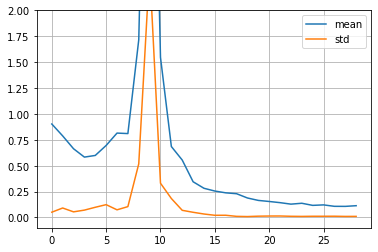

In [7]:
df = pd.DataFrame(l_f)
df.plot(grid=True)
mpl.ylim(-0.1, 2)
mpl.show()

pd.DataFrame(l_f)

In [8]:
#With the neural network

d = 100
n_train = 300
n_test = 300

N_SPACE = np.arange(0.1, 2, 0.1)

l = []

for i, N in enumerate(N_SPACE):
    N = int(N*n_train)
    print(f"progress {100*i/len(N_SPACE):.2f}%, N = {N}")
    l0 = []
    for _ in range(5):
        x_train, y_train, x_test, y_test = get_dataset(d, n_train, n_test)
        nn = Network(N, d, Relu, Linear)
        config = dict(
            nb_iterations=10, 
            batch_size=n_train, 
            learning_rate1=0., 
            learning_rate2=0.001
        )        
        loss_func = reg_MSE(nn.weights, 10**(-8))
        history = nn.fit(x_train, y_train, x_test, y_test, loss_func, **config)
        test_prediction = nn.predict(x_test)
        final_test_error = MSE.loss(y_test, test_prediction)
        l0.append(final_test_error)
        print(final_test_error)
    l0 = np.array(l0)
    l.append({"mean": l0.mean(), "std": l0.std()})


progress 0.00%, N = 30
1.4044715454776184
1.8297361084167696
1.3239693249441955
1.316839455589648
1.5934946588869847
progress 5.26%, N = 60
1.473280875857926
1.2631005507712822
1.2370556358862508
1.2939275642728865
1.139692486141949
progress 10.53%, N = 90
1.6051856767995554
1.5533373046322747
1.2813524147875255
1.4557207435843265
1.3729275936676626
progress 15.79%, N = 120
1.8388098914950524
1.641516374582232
1.5397102076321414
1.2234096657123261
2.29935598550003
progress 21.05%, N = 150
1.1363937371004749
1.2485508212267313
1.1982842389767234
1.8789538202152616
1.6242761357553115
progress 26.32%, N = 180
1.6557578523692764
1.4595992035959375
1.1553688568574687
1.3994020461755652
1.3270613835824747
progress 31.58%, N = 210
1.287819119281579
1.6177806345994497
1.2930160095107481
1.6515415544387104
1.2702201891034273
progress 36.84%, N = 240
1.4022261307691792
1.4191556977064332
1.4251440686910875
1.393147974710588
1.456308477061381
progress 42.11%, N = 270
1.3314455824097895
1.51926596

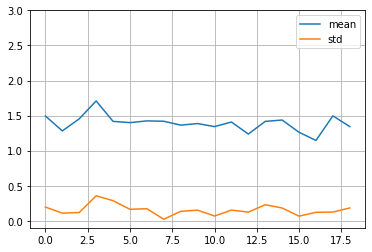

In [9]:
df = pd.DataFrame(l)
df.plot(grid=True)
mpl.ylim(-0.1, 3)
mpl.show()

In [24]:
param=0.1

n_train = 300
n_test = n_train
d = 100
N = int(param*n_train)

x_train, y_train, x_test, y_test = get_dataset(d, n_train, 300)

nn = Network(N, d, Relu, Linear)
config = dict(
    nb_iterations=500, 
    batch_size=n_train, 
    learning_rate1=0., 
    learning_rate2=0.0001
)
print(x_train.shape)
print(nn.dimensions)
print(nn.weights[1].shape)
loss_func = reg_MSE(nn.weights, 10**(-8))
history = nn.fit(x_train, y_train, x_test, y_test, loss_func, **config)
print(history[-1])
test_prediction = nn.predict(x_test)
final_test_error = nn.loss_function.loss(y_test, test_prediction)
print(final_test_error)

(300, 100)
(100, 30, 1)
(100, 30)
{'train_mse': 1.2523923983325498, 'test_mse': 1.2263104841192258}
1.2263104841192258


In [25]:
beta_nn = nn.weights[2]

x_train = Relu.function(np.dot(x_train, nn.weights[1]))
x_test = Relu.function(np.dot(x_test, nn.weights[1]))

beta_calc = np.dot(np.dot(np.linalg.inv(np.dot(x_test.T, x_test) + 0.01 * np.eye(x_test.shape[1], x_test.shape[1])), x_test.T), y_test)
print(beta_nn)
print(beta_calc)
print(mean_squared_error(beta_calc, beta_nn))

[[ 0.26903098]
 [-0.11342305]
 [ 0.16013062]
 [ 0.03866668]
 [ 0.08962705]
 [-0.06905976]
 [-0.01594037]
 [-0.22360469]
 [ 0.19472526]
 [ 0.16062124]
 [-0.3058638 ]
 [-0.18690907]
 [ 0.18409096]
 [-0.1642776 ]
 [-0.19440814]
 [ 0.15961029]
 [-0.13031509]
 [ 0.02052135]
 [-0.16251149]
 [ 0.04784831]
 [-0.10223918]
 [ 0.06049747]
 [-0.07480084]
 [ 0.05330413]
 [ 0.1960863 ]
 [-0.00335927]
 [ 0.0986112 ]
 [ 0.23808605]
 [-0.04154965]
 [-0.0376787 ]]
[[ 0.04115813]
 [-0.10251857]
 [ 0.04621898]
 [ 0.10469137]
 [-0.13065167]
 [-0.25559262]
 [ 0.01151853]
 [-0.09832256]
 [ 0.12064112]
 [-0.03890963]
 [ 0.06822301]
 [ 0.01638369]
 [-0.13061274]
 [ 0.01965809]
 [ 0.07885913]
 [-0.06646638]
 [ 0.14540615]
 [-0.2744744 ]
 [-0.02045711]
 [ 0.37211923]
 [-0.21410119]
 [ 0.02922457]
 [ 0.22503568]
 [ 0.05226723]
 [ 0.03290715]
 [ 0.11757582]
 [-0.19077318]
 [-0.17908756]
 [ 0.1160581 ]
 [ 0.01598563]]
0.0457631014999355


##### pd.DataFrame(l)